# Setup

In [13]:
# --- 1. SETUP DAN INSTALASI ---
!pip install transformers torch scikit-learn pandas


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import torch
import pandas as pd
# 1. Hapus 'AdamW' dari baris ini
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss
# 2. Tambahkan baris ini untuk mengimpor AdamW dari torch
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import time
import random

In [15]:
# Tentukan device (GPU jika ada, jika tidak CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# Untuk hasil yang konsisten
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Menggunakan device: cuda


# Persiapan Data

In [16]:
# --- 2. MEMUAT DATA BERSIH (YANG SUDAH ADA LABEL SENTIMEN) ---

# Asumsi skrip ini ada di 'Rule Bases', dan data ada di '../Dataset'
file_path = '../Dataset/Data-Bersih-Untuk-BERT.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Berhasil memuat {len(df)} baris data bersih dari: {file_path}")

    # Hapus jika ada teks yang kosong
    df = df.dropna(subset=['normalized_text', 'sentiment_pred'])

    print("\nDistribusi Sentimen (dari file):")
    print(df['sentiment_pred'].value_counts())

except FileNotFoundError:
    print(f"ERROR: File '{file_path}' tidak ditemukan.")
    print("Pastikan path Anda sudah benar.")

Berhasil memuat 2011 baris data bersih dari: ../Dataset/Data-Bersih-Untuk-BERT.csv

Distribusi Sentimen (dari file):
sentiment_pred
Negatif    1083
Netral      760
Positif     168
Name: count, dtype: int64


## PERSIAPAN DATA (PREPROCESSING & SPLIT)

In [17]:
# A. Konversi Label (String ke Angka)
# Gunakan nilai STRING yang TEPAT dari kolom 'sentiment_pred' Anda
label_map = {'Positif': 2, 'Netral': 1, 'Negatif': 0}
label_map_inv = {v: k for k, v in label_map.items()} # Untuk evaluasi

# Terapkan pemetaan
df['label_id'] = df['sentiment_pred'].map(label_map)

# Pastikan semua label berhasil terpetakan
df_final = df.dropna(subset=['label_id'])
df_final['label_id'] = df_final['label_id'].astype(int)

print(f"\nData setelah konversi label (contoh):\n{df_final[['normalized_text', 'sentiment_pred', 'label_id']].head()}")

# B. Siapkan teks dan label
texts = df_final['normalized_text'].values
labels = df_final['label_id'].values

# C. Split Data (Train, Validation, Test)
# 80% (Train+Val) dan 20% (Test)
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,       # 20% untuk data Test
    random_state=SEED,
    stratify=labels      # PENTING untuk data imbalanced
)

# Split 80% tadi menjadi 80% Train dan 20% Validation (64% Train, 16% Val)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,       # 20% dari 80% data awal
    random_state=SEED,
    stratify=train_val_labels
)

print(f"\nDistribusi Data:")
print(f"Data Latih (Train): {len(train_texts)}")
print(f"Data Validasi (Val): {len(val_texts)}")
print(f"Data Uji (Test):    {len(test_texts)}")

# D. Penanganan Data Imbalance (Class Weighting)
# Ini penting karena data Anda imbalanced (Positif: 168, Negatif: 1083)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"\nClass Weights (untuk kelas 0, 1, 2): {class_weights_tensor}")
print("Kelas 'Positif' (minoritas) akan memiliki bobot tertinggi.")


Data setelah konversi label (contoh):
                                     normalized_text sentiment_pred  label_id
0  ya beda blok jaman moh hatta jadi wapres indon...        Negatif         0
1  knp ini menteri gak mengundurkan diri cuma uta...        Negatif         0
2  pak punya menteri kok gini banget pak ngawur l...        Negatif         0
3  wakil menteri leveeeeel receeeeh level jalanan...        Negatif         0
4  klw berargumen itu emang kerjaan pemerintah ya...        Negatif         0

Distribusi Data:
Data Latih (Train): 1286
Data Validasi (Val): 322
Data Uji (Test):    403

Class Weights (untuk kelas 0, 1, 2): tensor([0.6186, 0.8820, 4.0062], device='cuda:0')
Kelas 'Positif' (minoritas) akan memiliki bobot tertinggi.


In [18]:
# --- 4. TOKENISASI (Versi IndoBERT) ---

model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 128 # Panjang token untuk Twitter

print("Melakukan tokenisasi data latih...")
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=MAX_LEN)
print("Melakukan tokenisasi data validasi...")
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=MAX_LEN)
print("Melakukan tokenisasi data uji...")
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=MAX_LEN)
print("Tokenisasi selesai.")

Melakukan tokenisasi data latih...
Melakukan tokenisasi data validasi...
Melakukan tokenisasi data uji...
Tokenisasi selesai.


# Modeling


## PyTorch

In [19]:
# --- 5. MEMBUAT PYTORCH DATASET & DATALOADER ---

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Buat objek Dataset
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

BATCH_SIZE = 16

# Buat DataLoader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)
print(f"DataLoader siap dengan batch size {BATCH_SIZE}")

DataLoader siap dengan batch size 16


## Fine Tuning

In [20]:
# --- 6. PELATIHAN MODEL (FINE-TUNING) ---

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map) # 3 label
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
EPOCHS = 4 # 3-5 epoch biasanya cukup
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Tentukan Loss Function DENGAN BOBOT KELAS (Handle Imbalance)
loss_fct = CrossEntropyLoss(weight=class_weights_tensor)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print("Memulai Pelatihan...")
for epoch_i in range(0, EPOCHS):
    print(f"\n--- Epoch {epoch_i + 1} / {EPOCHS} ---")
    start_time_epoch = time.time()

    # === TRAINING ===
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        model.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fct(logits, labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Rata-rata loss training: {avg_train_loss:.4f}")

    # === VALIDATION ===
    model.eval()
    total_eval_loss = 0
    total_eval_accuracy = 0

    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        loss = loss_fct(logits, labels)
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        labels_id = labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, labels_id)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)
    epoch_time = time.time() - start_time_epoch

    print(f"  Akurasi Validasi: {avg_val_accuracy:.4f}")
    print(f"  Loss Validasi:    {avg_val_loss:.4f}")
    print(f"  Waktu Epoch: {epoch_time:.2f} detik")

print("\n--- Pelatihan Selesai ---")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Memulai Pelatihan...

--- Epoch 1 / 4 ---
  Rata-rata loss training: 0.8272
  Akurasi Validasi: 0.7827
  Loss Validasi:    0.5889
  Waktu Epoch: 33.97 detik

--- Epoch 2 / 4 ---
  Rata-rata loss training: 0.4178
  Akurasi Validasi: 0.7708
  Loss Validasi:    0.4708
  Waktu Epoch: 33.97 detik

--- Epoch 3 / 4 ---
  Rata-rata loss training: 0.1561
  Akurasi Validasi: 0.8482
  Loss Validasi:    0.4864
  Waktu Epoch: 33.98 detik

--- Epoch 4 / 4 ---
  Rata-rata loss training: 0.0771
  Akurasi Validasi: 0.8512
  Loss Validasi:    0.5513
  Waktu Epoch: 33.98 detik

--- Pelatihan Selesai ---


In [21]:
# --- 7. SIMPAN MODEL & TOKENIZER ---

# Asumsi Anda ingin menyimpannya di dalam folder skrip Anda
output_model_dir = './model_sentiment_indobert_final'

os.makedirs(output_model_dir, exist_ok=True)

model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)

print(f"Model dan tokenizer telah disimpan di folder '{output_model_dir}'")

Model dan tokenizer telah disimpan di folder './model_sentiment_indobert_final'


In [22]:
# --- 8. EVALUASI AKHIR PADA TEST SET ---

print("\n--- Mengevaluasi pada Test Set (Data Uji) ---")
model.eval()

all_predictions = []
all_true_labels = []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    labels_id = labels.to('cpu').numpy()

    all_predictions.extend(np.argmax(logits, axis=1).flatten())
    all_true_labels.extend(labels_id.flatten())

# Konversi nama label dari ID (0, 1, 2) kembali ke string
target_names = [label_map_inv[i] for i in range(len(label_map))]

# --- TAMPILKAN HASILNYA ---
print("\n--- HASIL KLASIFIKASI (EVALUASI AKHIR) ---")
print("Ini adalah hasil performa model (Jawaban Rumusan Masalah #3 Anda):")
print(classification_report(
    all_true_labels,
    all_predictions,
    target_names=target_names
))


--- Mengevaluasi pada Test Set (Data Uji) ---

--- HASIL KLASIFIKASI (EVALUASI AKHIR) ---
Ini adalah hasil performa model (Jawaban Rumusan Masalah #3 Anda):
              precision    recall  f1-score   support

     Negatif       0.84      0.89      0.87       217
      Netral       0.87      0.79      0.83       152
     Positif       0.69      0.74      0.71        34

    accuracy                           0.84       403
   macro avg       0.80      0.80      0.80       403
weighted avg       0.84      0.84      0.84       403



# Visualisasi

## Confussion Matrix


--- Membuat Confusion Matrix ---



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Gambar Confusion Matrix telah disimpan ke: confusion_matrix.png


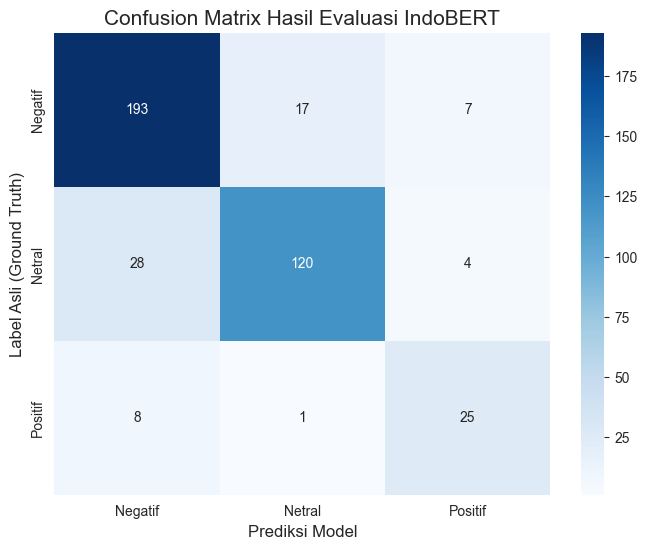

In [24]:
# --- 9. VISUALISASI CONFUSION MATRIX ---
# Pastikan Anda sudah menginstal seaborn
!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("\n--- Membuat Confusion Matrix ---")

# 1. Hitung Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# 2. Ambil nama label (target_names) yang sudah kita buat di sel sebelumnya
# (Harusnya: ['Negatif', 'Netral', 'Positif'])
labels = target_names

# 3. Buat Plot menggunakan Seaborn Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,     # Tampilkan angka di dalam kotak
    fmt='d',        # Format angka sebagai integer (digit)
    cmap='Blues',   # Skema warna
    xticklabels=labels,
    yticklabels=labels
)

plt.title('Confusion Matrix Hasil Evaluasi IndoBERT', fontsize=15)
plt.ylabel('Label Asli (Ground Truth)', fontsize=12)
plt.xlabel('Prediksi Model', fontsize=12)

# 4. Simpan file plot
output_plot_path = 'confusion_matrix.png'
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')

print(f"Gambar Confusion Matrix telah disimpan ke: {output_plot_path}")
plt.show()